# **INTELIGENCIA DEL NEGOCIO / Business Intelligence**
## **ASSIGNMENT A1 - MULTILAYER PERCEPTRON**

**INSTRUCCIONES / RECOMENDACIONES**

- Se recomienda leer con detalle la descripción de cada una de las celdas.
- Las celdas que ya tienen código, se deberán ejecutar directamente.
- Las celdas que están vacías, se completarán con la implementación requerida en el notebook.
- No se incluirán más celdas de las establecidas en el presente notebook, por lo que la solución al mismo deberá implementarse exclusivamente en las celdas vacías.
- Scikit-Learn es un paquete muy útil para las operaciones de preprocesamiento de los datos, como estandarización, normalización, codificación, etc.
- Recuerda poner nombre a todas las layers de Keras, facilitará mucho las cosas a la hora de depurar errores.
- Si ves que un apartado es complejo, intenta escribir y ejecutarlo de forma simplificada (por ejemplo, con menos layers o con menos features) y después vaya amplíandolo.
- La entrega se realizará vía Moodle. Será necesario subir la solución a este notebook con el nombre: **NOMBRE_GRUPO.ipynb**

- **Fecha de Publicación: 05/02/2024**
- **Fecha de Entrega: 11/02/2024**
- **Test: 12/02/2024**


# Carga de librerías

In [1]:
import pandas as pd
import random
random.seed(0)
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

In [2]:
print("TF VERSION: ", tf.__version__)
print("SKLEARN VERSION: ", sklearn.__version__)
print("PANDAS VERSION: ", pd.__version__)
print("MATPLOTLIB VERSION: ", sklearn.__version__)

TF VERSION:  2.15.0
SKLEARN VERSION:  1.2.2
PANDAS VERSION:  1.5.3
MATPLOTLIB VERSION:  1.2.2


# Carga dataset

Se va a usar un dataset que contiene información socieconómica de ciudadanos americanos.

Queremos construir un modelo que realice predicciones a partir de estas features, utilizando la variable "income" como salida al modelo, la cual indica si la persona tiene unos ingresos superiores o inferirores a 50K. Es por tanto un problema de clasificación binaria.

Puede ver descripciones de los datos en el siguiente link:

https://archive.ics.uci.edu/ml/datasets/census+income

El dataset es muy grande, vamos a tomar solamente algunas de sus muestras.

In [3]:
pd_data = pd.read_csv("income_evaluation.csv").sample(5_000)

In [4]:
for c in pd_data.columns:
    pd_data = pd_data.rename(columns={c: c.replace(" ", "")})

In [5]:
TARGET = "income"
NUMERICAL_COLUMNS = ["age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week", "education-num"]
CATEGORICAL_COLUMNS = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

Divida el dataset en train y test. Un 20% en test puede ser suficiente.

In [6]:
pd_train, pd_test = sklearn.model_selection.train_test_split(pd_data, test_size=0.2, shuffle=True)

In [7]:
print("SAMPLES TRAIN: ", len(pd_train))
print("SAMPLES TEST: ", len(pd_test))

SAMPLES TRAIN:  4000
SAMPLES TEST:  1000


# Analisis

Realice un análisis de las variables en el dataset.
Sugerencias:
- Histogramas de las variables
- Detectar y eliminar variables que no parezcan predecir el target o si presentan alta correlación con alguna otra de las features.
- En las variables categóricas, tomar aquellas etiquetas con baja volumetría y unirlas en un etiqueta default.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 23174 to 9566
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             4000 non-null   int64 
 1   workclass       4000 non-null   object
 2   fnlwgt          4000 non-null   int64 
 3   education       4000 non-null   object
 4   education-num   4000 non-null   int64 
 5   marital-status  4000 non-null   object
 6   occupation      4000 non-null   object
 7   relationship    4000 non-null   object
 8   race            4000 non-null   object
 9   sex             4000 non-null   object
 10  capital-gain    4000 non-null   int64 
 11  capital-loss    4000 non-null   int64 
 12  hours-per-week  4000 non-null   int64 
 13  native-country  4000 non-null   object
 14  income          4000 non-null   object
dtypes: int64(6), object(9)
memory usage: 500.0+ KB


<ipython-input-11-8788aedf844b>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(pd_train.corr())


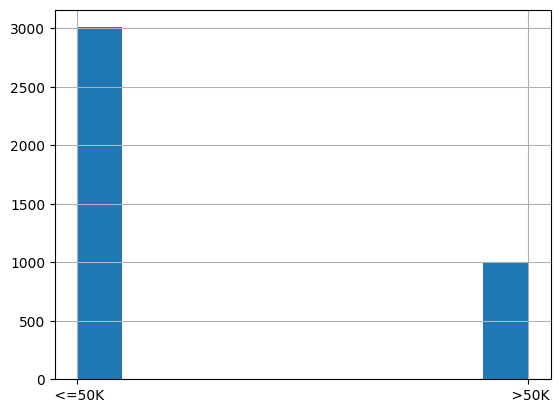

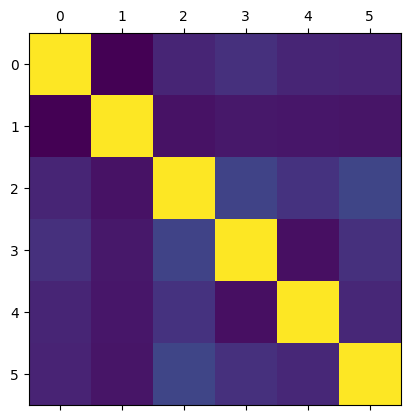

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,4000.000000,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000
mean,38.763250,1.908319e+05,10.097750,1015.126500,89.441500,40.190750
std,13.740065,1.076002e+05,2.573879,7114.692544,405.435764,12.438671
min,17.000000,1.487800e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175005e+05,9.000000,0.000000,0.000000,40.000000
50%,38.000000,1.802115e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.397678e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.125613e+06,16.000000,99999.000000,3900.000000,99.000000


In [11]:
pd_train.info()

pd_train[TARGET].hist();

plt.matshow(pd_train.corr())
plt.show()

pd_train.describe()

# Preprocesado del target

Aplique una trasformación en el target para convertirlo en unos y ceros.

In [13]:
label_encoder = LabelEncoder().fit(pd_train[TARGET])
y_train = label_encoder.transform(pd_train[TARGET])
y_test = label_encoder.transform(pd_test[TARGET])

# Preprocesado de las variables numéricas.

Vamos a comenzar construyendo un modelo usando solo variables numéricas ya que son las más sencillas de tratar. Para empezar, aplique una transformación en las features para normalizarlas a media cero y desviación típica uno.

In [14]:
scaler = StandardScaler().fit(pd_train[NUMERICAL_COLUMNS])
X_numeric_train = scaler.transform(pd_train[NUMERICAL_COLUMNS])
X_numeric_test = scaler.transform(pd_test[NUMERICAL_COLUMNS])

# Modelo baseline de variables continuas

Construya una regresión logística a partir de las features transformadas. Use el dataset de test para evaluar el modelo y calcule el accuracy, precision, recall, f1 y área bajo la curva. ¿Cuál crees que es la mejor métrica para evaluar este problema?

In [15]:
lr = LogisticRegression()
lr.fit(X_numeric_train, y_train)

LogisticRegression()

In [16]:
predictions_test = lr.predict(X_numeric_test)
predictions_proba_test = lr.predict_proba(X_numeric_test)

In [17]:
print("TEST ACCURACY: ", sklearn.metrics.accuracy_score(y_test, predictions_test))
print("TEST RECALL: ", sklearn.metrics.recall_score(y_test, predictions_test))
print("TEST PRECISION: ", sklearn.metrics.precision_score(y_test, predictions_test))
print("TEST F1: ", sklearn.metrics.f1_score(y_test, predictions_test))
print("TEST AUC", sklearn.metrics.roc_auc_score(y_test, predictions_proba_test[:, 1]))

TEST ACCURACY:  0.806
TEST RECALL:  0.37339055793991416
TEST PRECISION:  0.6444444444444445
TEST F1:  0.4728260869565217
TEST AUC 0.8208784014414333


# Modelo Deep Learning

Construya un perceptrón multicapa para predecir el target.

## Construcción del modelo
Construye el modelo con Keras. Utilice varias capas (entre 1 y 2 serán suficiente). Puede probar varios valores para el número de capas y el tamaño de las mismas. Considere añadir capas de Dropout entre algunas (o todas) las capas.

In [2]:
HIDDEN_SIZES = [10,3]
for i, h in enumerate(HIDDEN_SIZES): 
    print(i,h)

0 10
1 3


In [18]:
HIDDEN_SIZES = [10, 3]
inputs = tf.keras.layers.Input(shape=(X_numeric_train.shape[-1], ), name="numeric_input")
x = inputs
for i, h in enumerate(HIDDEN_SIZES):
    x = tf.keras.layers.Dense(h, activation="relu", name=f"hidden_layer_{i+1}")(x)
y = tf.keras.layers.Dense(1, activation="sigmoid", name="last_layer")(x)
numeric_model = tf.keras.models.Model(inputs, y, name="continuos_model")
numeric_model.summary()

Model: "continuos_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 numeric_input (InputLayer)  [(None, 6)]               0         
                                                                 
 hidden_layer_1 (Dense)      (None, 10)                70        
                                                                 
 hidden_layer_2 (Dense)      (None, 3)                 33        
                                                                 
 last_layer (Dense)          (None, 1)                 4         
                                                                 
Total params: 107 (428.00 Byte)
Trainable params: 107 (428.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compilación del modelo
Compile el modelo con adam como función de optimización. Elija la función de pérdida acorde con el objetivo que buscamos. Además, elija algunas métricas que nos permitan evaluar el modelo.

In [19]:
numeric_model.compile(tf.keras.optimizers.Adam(learning_rate=5e-3), loss="binary_crossentropy",
                      metrics=["accuracy", tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision"),
                              tf.keras.metrics.AUC(name="auc")])

## Entrenamiento

Entrene el modelo. Elija el tamaño del batch y el número de épocas necesario. Utilice algunas de las técnicas mencionadas en clase para evitar el overfitting del modelo.

In [20]:
history = numeric_model.fit(X_numeric_train, y_train, validation_split=0.2, epochs=35, batch_size=128, verbose=1)

Epoch 1/35
25/25 [==============================] - 7s 34ms/step - loss: 0.6422 - accuracy: 0.6928 - recall: 0.1838 - precision: 0.2996 - auc: 0.5714 - val_loss: 0.5676 - val_accuracy: 0.7650 - val_recall: 0.0887 - val_precision: 0.8571 - val_auc: 0.6946
Epoch 2/35
25/25 [==============================] - 0s 6ms/step - loss: 0.4832 - accuracy: 0.7806 - recall: 0.1812 - precision: 0.7186 - auc: 0.7741 - val_loss: 0.4150 - val_accuracy: 0.8025 - val_recall: 0.3448 - val_precision: 0.7368 - val_auc: 0.8448
Epoch 3/35
25/25 [==============================] - 0s 5ms/step - loss: 0.4101 - accuracy: 0.8100 - recall: 0.4043 - precision: 0.6980 - auc: 0.8362 - val_loss: 0.3833 - val_accuracy: 0.8275 - val_recall: 0.4926 - val_precision: 0.7407 - val_auc: 0.8620
Epoch 4/35
25/25 [==============================] - 0s 7ms/step - loss: 0.3977 - accuracy: 0.8184 - recall: 0.4880 - precision: 0.6851 - auc: 0.8437 - val_loss: 0.3799 - val_accuracy: 0.8313 - val_recall: 0.5123 - val_precision: 0.7429 -

El método fit devuelve un objeto de tipo history con las métricas obtenidas durante el entrenamiento. Analice el resultado de ejecutar 'history.history' y dibuje las métricas en las distintas épocas.

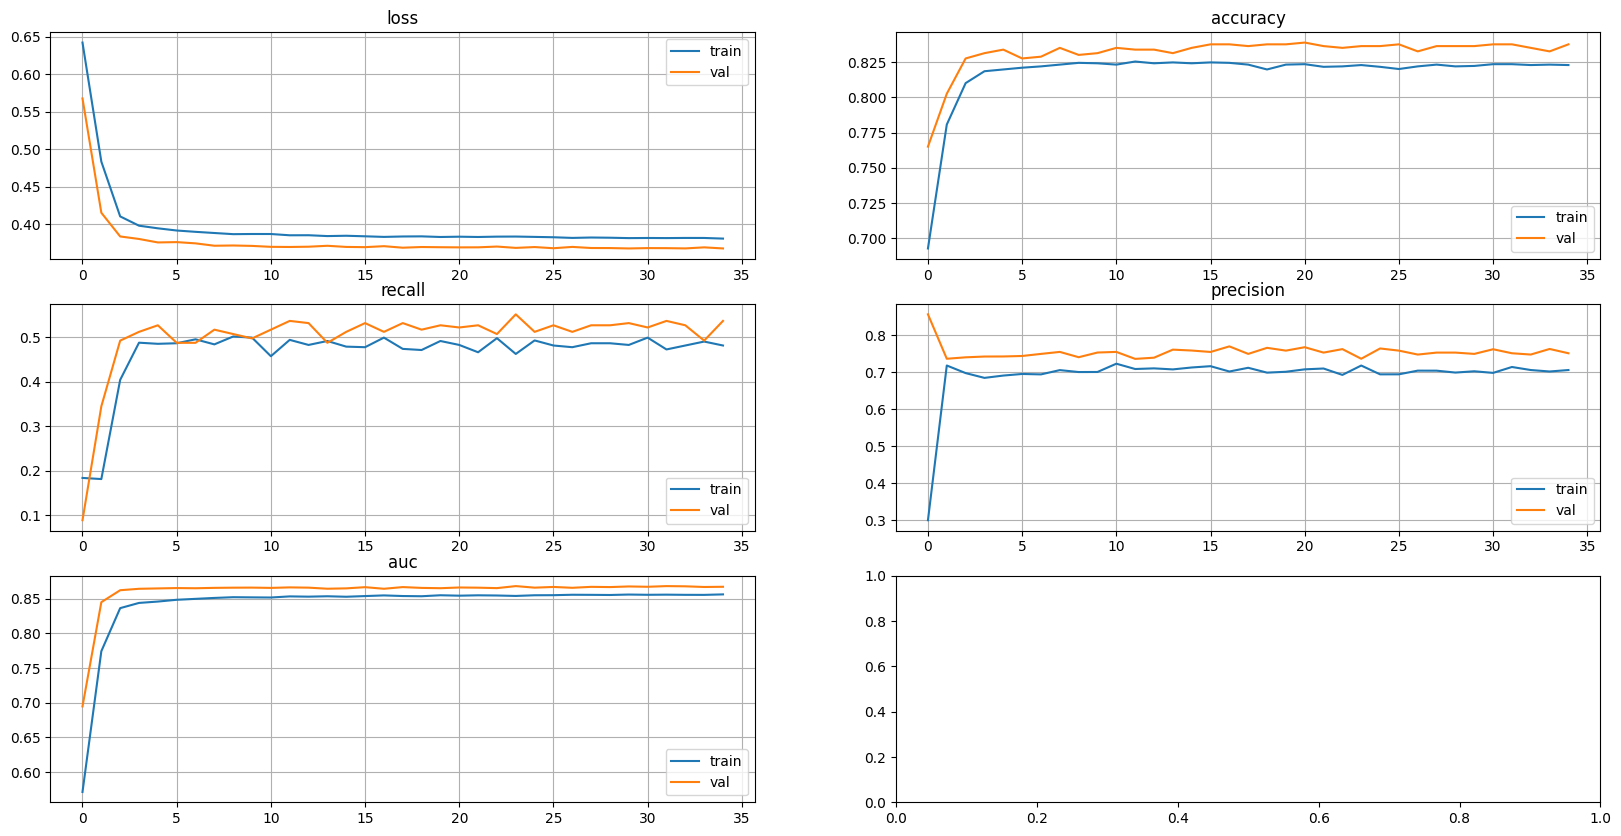

In [21]:
metrics = [m for m in history.history.keys() if "val_" not in m]
fig, axs = plt.subplots(int(np.ceil(len(metrics) / 2)), 2, figsize=(20, 10))
for ax, m in zip(axs.flatten(), metrics):
    ax.plot(history.history[m], label="train")
    ax.plot(history.history["val_" + m], label="val")
    ax.set_title(m)
    ax.legend()
    ax.grid()


## Evaluación

Utilice el dataset de test para conseguir las métricas que se calcularon con el modelo baseline. Compare los resultados con el baseline.

In [22]:
predictions_proba_test = numeric_model.predict(X_numeric_test)
predictions_test = np.round(predictions_proba_test)

32/32 [==============================] - 0s 2ms/step


In [23]:
print("TEST ACCURACY: ", sklearn.metrics.accuracy_score(y_test, predictions_test))
print("TEST RECALL: ", sklearn.metrics.recall_score(y_test, predictions_test))
print("TEST PRECISION: ", sklearn.metrics.precision_score(y_test, predictions_test))
print("TEST F1: ", sklearn.metrics.f1_score(y_test, predictions_test))
print("TEST AUC", sklearn.metrics.roc_auc_score(y_test, predictions_proba_test))

TEST ACCURACY:  0.807
TEST RECALL:  0.4206008583690987
TEST PRECISION:  0.6282051282051282
TEST F1:  0.5038560411311054
TEST AUC 0.8382332369020374


## Impacto del learning rate

Reentrene el modelo varias veces usando diferentes learning rate (por ejemplo, en escala logarítmica valores entre 1e-6 y 1) y dibuje los resultados en validación de la métrica de loss para cada valor del learning rate.

¿cuál es el mejor valor del learning rate?

No olvidar reinicializar los pesos entre entrenamiento y entrenamiento. Para ello, se puede usar la siguiente función:

In [24]:
from tensorflow import keras
def reinitialize_model(model):
    weights = []
    initializers = []
    for layer in model.layers:
        if isinstance(layer, (keras.layers.Dense, keras.layers.Conv2D)):
            weights += [layer.kernel, layer.bias]
            initializers += [layer.kernel_initializer, layer.bias_initializer]
        elif isinstance(layer, keras.layers.BatchNormalization):
            weights += [layer.gamma, layer.beta, layer.moving_mean, layer.moving_variance]
            initializers += [layer.gamma_initializer,
                           layer.beta_initializer,
                           layer.moving_mean_initializer,
                           layer.moving_variance_initializer]
    for w, init in zip(weights, initializers):
        w.assign(init(w.shape, dtype=w.dtype))
reinitialize_model(numeric_model)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [25]:
EPOCHS = 40
learning_rates = 1/np.power(10, np.arange(0, 10), )
scores = []
histories = []
for lr in learning_rates:
    reinitialize_model(numeric_model)
    numeric_model.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss="binary_crossentropy",
                          metrics=["accuracy", tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision"),
                                  tf.keras.metrics.AUC(name="auc")])

    history = numeric_model.fit(X_numeric_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=128, verbose=0)
    histories.append(history)
    scores.append(numeric_model.evaluate(X_numeric_test, y_test))

32/32 [==============================] - 0s 5ms/step - loss: 0.7072 - accuracy: 0.5410 - recall: 0.5536 - precision: 0.2665 - auc: 0.5351


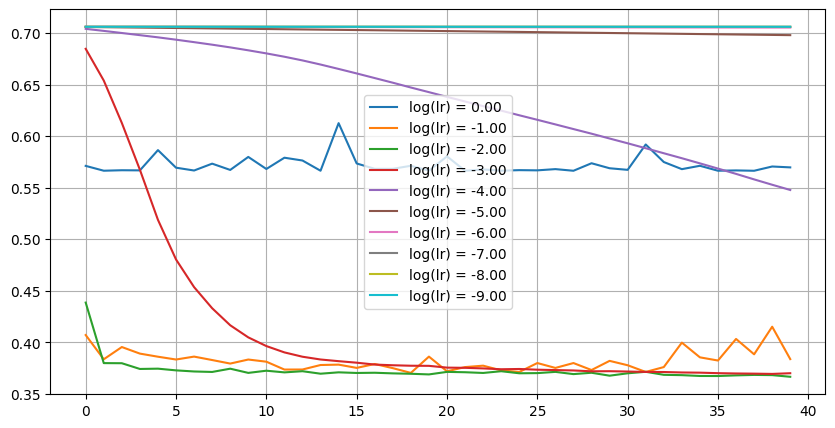

In [26]:
plt.figure(figsize=(10, 5))
for h, lr in zip(histories, learning_rates):
    plt.plot(h.history["val_loss"], label=f"log(lr) = {np.log10(lr):.2f}")
plt.grid()
plt.legend();

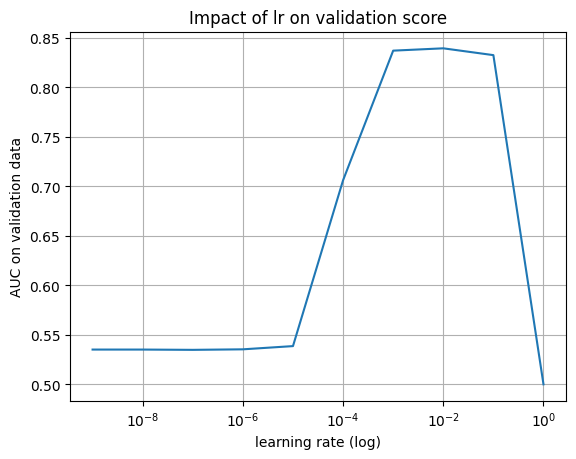

In [27]:
plt.plot(learning_rates, np.asarray([s[-1] for s in scores]))
plt.xscale('log')
plt.xlabel("learning rate (log)")
plt.ylabel("AUC on validation data")
plt.grid()
plt.title("Impact of lr on validation score");

# Preprocesado de variables categóricas

Vamos a construir un modelo con las variables categóricas. Comencemos generando variables one hot para poder alimentar un modelo con ellas.

In [28]:
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=100).fit(pd_train[CATEGORICAL_COLUMNS])
X_categorical_train = ordinal_encoder.transform(pd_train[CATEGORICAL_COLUMNS])
X_categorical_test = ordinal_encoder.transform(pd_test[CATEGORICAL_COLUMNS])

In [29]:
onehot_encoder = OneHotEncoder(handle_unknown="ignore").fit(pd_train[CATEGORICAL_COLUMNS])
X_categorical_onehot_train = onehot_encoder.transform(pd_train[CATEGORICAL_COLUMNS]).toarray()
X_categorical_onehot_test = onehot_encoder.transform(pd_test[CATEGORICAL_COLUMNS]).toarray()

# Modelo baseline de todas las variables

Vuelva a realizar un modelo de regresión logística usando las variables categóricas.

In [30]:
X_train = np.concatenate([X_numeric_train, X_categorical_onehot_train], axis=-1)
X_test = np.concatenate([X_numeric_test, X_categorical_onehot_test], axis=-1)

In [31]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [32]:
predictions_test = lr.predict(X_test)
predictions_proba_test = lr.predict_proba(X_test)

In [33]:
print("TEST ACCURACY: ", sklearn.metrics.accuracy_score(y_test, predictions_test))
print("TEST RECALL: ", sklearn.metrics.recall_score(y_test, predictions_test))
print("TEST PRECISION: ", sklearn.metrics.precision_score(y_test, predictions_test))
print("TEST F1: ", sklearn.metrics.f1_score(y_test, predictions_test))
print("TEST AUC", sklearn.metrics.roc_auc_score(y_test, predictions_proba_test[:, 1]))

TEST ACCURACY:  0.833
TEST RECALL:  0.575107296137339
TEST PRECISION:  0.6633663366336634
TEST F1:  0.6160919540229886
TEST AUC 0.8840474285298612


# Modelo Deep Learning con todas las variables


## Construcción del modelo
Construye el modelo con Keras. Aunque hay muchas maneras de hacerlo, se recomienda construir un modelo que tenga una entrada para las variables numéricas y otra entrada por cada una de las variables categóricas.

Cada variable categórica debe "enganchar" con una capa de Embedding, de forma que cada variable se transforme en un vector de dimensión D (puede elegir el valor de D, o incluso hacer que varíe según la variable en cuestión). Así debe finalizar teniendo un tensor asociado a cada una de las features.

Una los tensores en uno solo usando alguna capa de Merge (Concatenación, Media ...) Finalmente, aplique varias capas ocultas estudiando varias posibilidades.

In [34]:
len(ordinal_encoder.categories_[1])

16

In [35]:
HIDDEN_SIZES = [10, 3]
embedding_size = 10

inputs_numerical = tf.keras.layers.Input(shape=(X_numeric_train.shape[-1], ), name="numerical")
x_numerical = tf.keras.layers.Dense(embedding_size, activation="sigmoid")(inputs_numerical)

inputs_categorical = [tf.keras.layers.Input(shape=(1, ), name=c) for c in CATEGORICAL_COLUMNS]
embeddings = [tf.keras.layers.Embedding(len(ordinal_encoder.categories_[i]), embedding_size, name=f"embedding_{c}") for i, c in enumerate(CATEGORICAL_COLUMNS)]
x_categoricals = [e(x) for e, x in zip(embeddings, inputs_categorical)]

x = tf.keras.layers.Average()([x_numerical] + x_categoricals)
for i, h in enumerate(HIDDEN_SIZES):
    x = tf.keras.layers.Dense(h, activation="relu", name=f"hidden_layer_{i+1}")(x)

y = tf.keras.layers.Dense(1, activation="sigmoid", name="last_layer")(x)
all_feats_model = tf.keras.models.Model([inputs_numerical] + inputs_categorical, y, name="all_feats_model")
all_feats_model.summary()

Model: "all_feats_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 numerical (InputLayer)      [(None, 6)]                  0         []                            
                                                                                                  
 workclass (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 education (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 marital-status (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                  

## Compilación del modelo
Compile el modelo con adam como función de optimización. Elija la función de pérdida acorde con el objetivo que buscamos. Además, elija algunas métricas que nos permitan evaluar el modelo.

In [46]:
reinitialize_model(all_feats_model)

all_feats_model.compile(tf.keras.optimizers.Adam(5e-3),
                        "binary_crossentropy",
                       metrics=["accuracy", tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision"),
                               tf.keras.metrics.AUC(name="auc")])

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


## Entrenamiento

Entrene el modelo. Elija el tamaño del batch y el número de épocas necesario.

In [47]:
X_train = {"numerical": X_numeric_train, **{c: X_categorical_train[:, i] for i, c in enumerate(CATEGORICAL_COLUMNS)}}
X_test = {"numerical": X_numeric_test, **{c: X_categorical_test[:, i] for i, c in enumerate(CATEGORICAL_COLUMNS)}}

y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [48]:
history = all_feats_model.fit(X_train, y_train, epochs=40, verbose=1, validation_data=(X_test, y_test), batch_size=128)

Epoch 1/40
32/32 [==============================] - 21s 469ms/step - loss: 0.5849 - accuracy: 0.7520 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.5830 - val_loss: 0.4925 - val_accuracy: 0.7670 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.8519
Epoch 2/40
32/32 [==============================] - 5s 163ms/step - loss: 0.4468 - accuracy: 0.7738 - recall: 0.1260 - precision: 0.7669 - auc: 0.8586 - val_loss: 0.3916 - val_accuracy: 0.8260 - val_recall: 0.4549 - val_precision: 0.6928 - val_auc: 0.8586
Epoch 3/40
32/32 [==============================] - 5s 133ms/step - loss: 0.3622 - accuracy: 0.8360 - recall: 0.5423 - precision: 0.7270 - auc: 0.8839 - val_loss: 0.3795 - val_accuracy: 0.8210 - val_recall: 0.6094 - val_precision: 0.6174 - val_auc: 0.8683
Epoch 4/40
32/32 [==============================] - 2s 49ms/step - loss: 0.3433 - accuracy: 0.8447 - recall: 0.5978 - precision: 0.7276 - auc: 0.8958 - val_loss: 0.3706 - val_accuracy: 0.8350 - val_recall: 0.6395 - 

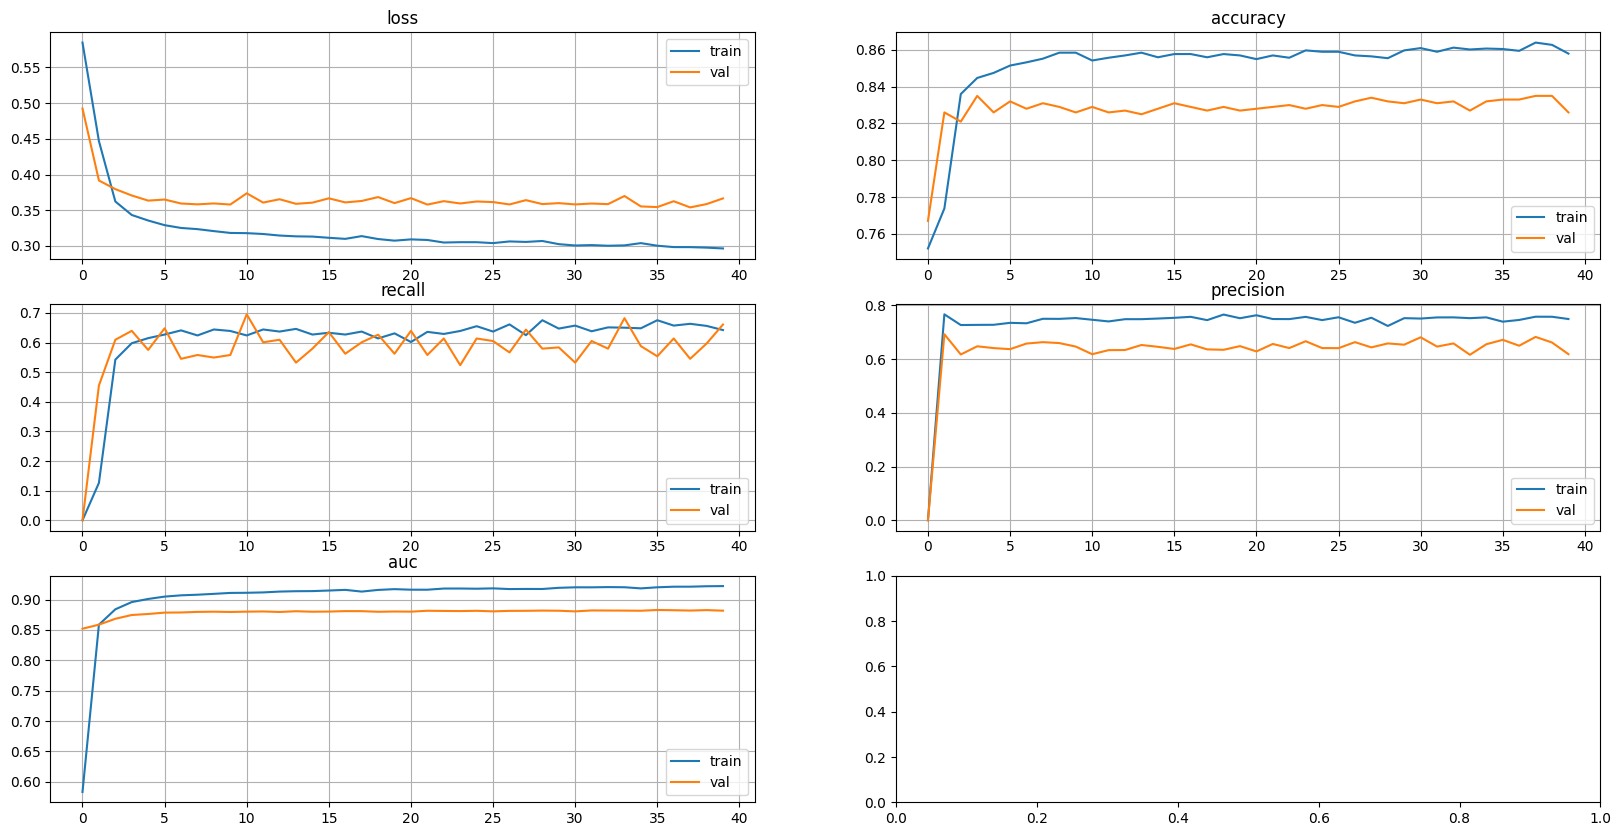

In [49]:
metrics = [m for m in history.history.keys() if "val_" not in m]
fig, axs = plt.subplots(int(np.ceil(len(metrics) / 2)), 2, figsize=(20, 10))
for ax, m in zip(axs.flatten(), metrics):
    ax.plot(history.history[m], label="train")
    ax.plot(history.history["val_" + m], label="val")
    ax.set_title(m)
    ax.legend()
    ax.grid()


## Evaluación

Utilice el dataset de test para conseguir las métricas que se calcularon con el modelo baseline. Compare los resultados con el baseline.

In [50]:
predictions_proba_test = all_feats_model.predict(X_test).flatten()
predictions_test = np.round(predictions_proba_test).flatten()

32/32 [==============================] - 1s 27ms/step


In [51]:
print("TEST ACCURACY: ", sklearn.metrics.accuracy_score(y_test, predictions_test))
print("TEST RECALL: ", sklearn.metrics.recall_score(y_test, predictions_test))
print("TEST PRECISION: ", sklearn.metrics.precision_score(y_test, predictions_test))
print("TEST F1: ", sklearn.metrics.f1_score(y_test, predictions_test))
print("TEST AUC", sklearn.metrics.roc_auc_score(y_test, predictions_proba_test))

TEST ACCURACY:  0.826
TEST RECALL:  0.6609442060085837
TEST PRECISION:  0.6184738955823293
TEST F1:  0.6390041493775934
TEST AUC 0.8821281286546435
